# 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [7]:
from tensorflow.keras.applications import ResNet50

# ResNet50 modelini yükle
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_model.keras', save_best_only=True, monitor='val_accuracy')
epochs = 100
# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 255s 898ms/step - accuracy: 0.7037 - loss: 0.9459 - val_accuracy: 0.8591 - val_loss: 0.4070
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 239s 870ms/step - accuracy: 0.8368 - loss: 0.4755 - val_accuracy: 0.8600 - val_loss: 0.3762
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 239s 868ms/step - accuracy: 0.8427 - loss: 0.4321 - val_accuracy: 0.8638 - val_loss: 0.3683
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 240s 873ms/step - accuracy: 0.8451 - loss: 0.4228 - val_accuracy: 0.8632 - val_loss: 0.3603
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 240s 873ms/step - accuracy: 0.8498 - loss: 0.4162 - val_accuracy: 0.8627 - val_loss: 0.3615
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 875ms/step - accuracy: 0.8464 - loss: 0.4123 - val_accuracy: 0.8632 - val_loss: 0.3548
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 874ms/step - accuracy: 0.8535 - loss: 0.4072 - val_accuracy: 0.8627 - val_loss: 0.3563
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 877ms/step - accuracy: 

In [10]:
# Test veri seti üzerinde modeli değerlendir
test_loss, test_accuracy = model.evaluate(test_dataset)

# Sonuçları yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.8656 - loss: 0.3625
Test Loss: 0.3472
Test Accuracy: 0.8627


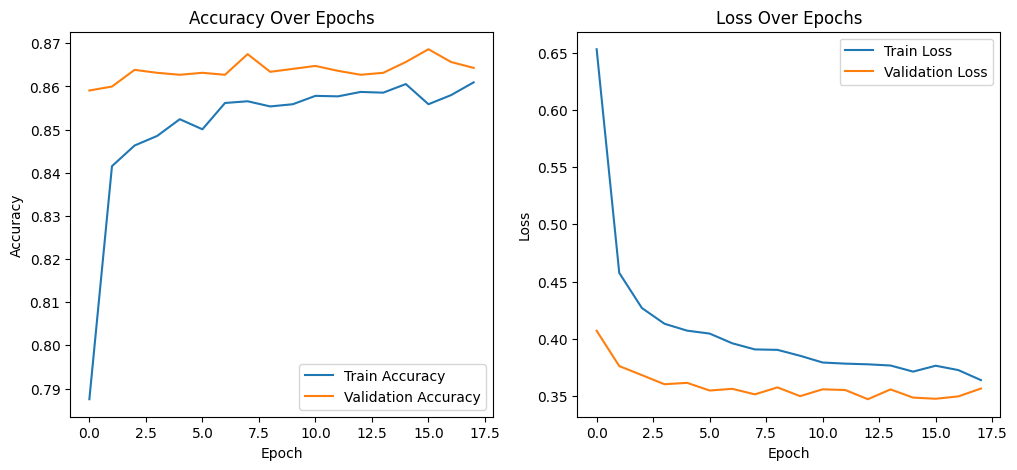

In [9]:
import matplotlib.pyplot as plt

# Accuracy ve loss değerlerini çizdirme
def plot_accuracy_loss(history):
    # Accuracy grafiği
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Grafikleri çizdir
plot_accuracy_loss(history)

Sınıf İsimleri: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
Seçilen Sınıf: D
Seçilen Görsel: /kaggle/input/classed-odir5k-splited-into-train-test/test/D/4369_left.jpg


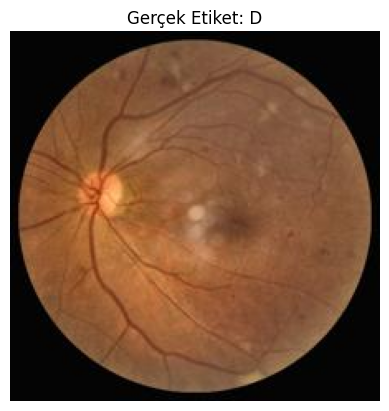

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Gerçek Etiket: D
Tahmin Edilen Etiket: D
Tahmin Olasılıkları: [6.5433286e-02 8.0833532e-04 4.1416442e-01 4.7987243e-03 7.1379855e-02
 2.4392231e-05 2.8796577e-01 1.5542516e-01]


In [47]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Test dizinindeki klasörleri (sınıfları) al
class_names = sorted(os.listdir(test_dir))  # Klasör adlarını al
print("Sınıf İsimleri:", class_names)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
print("Seçilen Sınıf:", random_class)

# Seçilen sınıftan rastgele bir görsel seç
random_image_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))
print("Seçilen Görsel:", random_image_path)

# Görseli yükle ve ön işleme yap
img = tf.keras.preprocessing.image.load_img(random_image_path, target_size=img_size)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği şekilde (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Görseli göster
plt.imshow(img)
plt.title(f"Gerçek Etiket: {random_class}")
plt.axis('off')
plt.show()

# Tahmin yap
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]  # En yüksek olasılığa sahip sınıf

# Sonucu yazdır
print(f"Gerçek Etiket: {random_class}")
print(f"Tahmin Edilen Etiket: {predicted_class}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

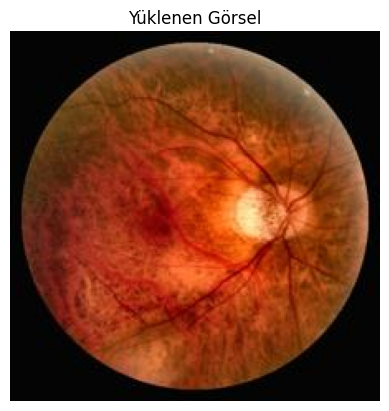

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Tahmin Edilen Sınıf: M
Tahmin Olasılıkları: [2.64078029e-03 1.04165214e-04 2.59574736e-03 3.66400112e-04
 3.71996521e-06 8.97099316e-01 9.36840475e-02 3.50572285e-03]


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Dışarıdan bir görsel yükle
image_path = "/kaggle/input/eski-veri-seti-snf-karm/M/106_right.jpg"  # Görselin yolunu buraya yazın
img = image.load_img(image_path, target_size=(224, 224))  # Görseli 224x224 boyutuna yeniden boyutlandır

# Görseli göster
plt.imshow(img)
plt.title("Yüklenen Görsel")
plt.axis('off')
plt.show()

# Görseli model için hazırla
img_array = image.img_to_array(img)  # Görseli numpy dizisine dönüştür
img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği şekilde (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Tahmin yap
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]  # En yüksek olasılığa sahip sınıf

# Sonucu yazdır
print(f"Tahmin Edilen Sınıf: {predicted_class}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

**Attention eklenmiş model**

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Multiply, Add, GlobalAveragePooling2D, Reshape, Dense, Permute

class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.global_avg_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(units=256 // self.ratio, activation='relu')  # Dinamik olarak ayarlanabilir
        self.dense2 = Dense(units=1, activation='sigmoid')  # Çıktı boyutu 1 olacak

    def build(self, input_shape):
        # Giriş şeklinden kanal sayısını al
        self.channels = input_shape[-1]
        self.dense1 = Dense(units=self.channels // self.ratio, activation='relu')
        self.dense2 = Dense(units=self.channels, activation='sigmoid')
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        # Global Average Pooling uygula
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = tf.expand_dims(avg_pool, axis=1)  # (batch_size, 1, channels)
        avg_pool = tf.expand_dims(avg_pool, axis=1)  # (batch_size, 1, 1, channels)

        # Dense katmanları uygula
        fc1 = self.dense1(avg_pool)
        fc2 = self.dense2(fc1)

        # Attention ağırlıklarını uygula
        return Multiply()([inputs, fc2])

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return Multiply()([inputs, attention])

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# ResNet50 modelini yükle
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
inputs = base_model.input
x = base_model.output

# Channel Attention ekle
x = ChannelAttention()(x)

# Spatial Attention ekle
x = SpatialAttention()(x)

# Global Average Pooling ve diğer katmanlar
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)

# Modeli oluştur
model = tf.keras.Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_attention_model.keras', save_best_only=True, monitor='val_accuracy')

# Epoch sayısını tanımla
epochs = 100  # İstediğiniz epoch sayısını burada belirtin

# Modeli eğit
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 271s 932ms/step - accuracy: 0.7233 - loss: 0.8193 - val_accuracy: 0.8600 - val_loss: 0.3752
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 246s 892ms/step - accuracy: 0.8473 - loss: 0.4118 - val_accuracy: 0.8611 - val_loss: 0.3700
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 242s 881ms/step - accuracy: 0.8560 - loss: 0.3878 - val_accuracy: 0.8657 - val_loss: 0.3580
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 242s 879ms/step - accuracy: 0.8605 - loss: 0.3757 - val_accuracy: 0.8604 - val_loss: 0.3570
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 877ms/step - accuracy: 0.8596 - loss: 0.3682 - val_accuracy: 0.8577 - val_loss: 0.3721
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 243s 884ms/step - accuracy: 0.8628 - loss: 0.3592 - val_accuracy: 0.8686 - val_loss: 0.3525
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 242s 878ms/step - accuracy: 0.8671 - loss: 0.3560 - val_accuracy: 0.8673 - val_loss: 0.3419
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 242s 878ms/step - accuracy: 

In [8]:
# Modeli test veri seti üzerinde değerlendir
test_loss, test_accuracy = model.evaluate(test_dataset)

# Test sonuçlarını yazdır
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Sınıflandırma raporu ve karışıklık matrisi için gerekli kütüphaneler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri seti üzerinde tahminler yap
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)  # Tahminleri sınıf indekslerine dönüştür

# Gerçek etiketleri topla
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)  # One-hot encoding'i sınıf indekslerine dönüştür

# Sınıflandırma raporu
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Karışıklık matrisi
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8614 - loss: 0.3408
Test Loss: 0.33068153262138367
Test Accuracy: 0.875455379486084
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       534
           1       0.98      0.97      0.98       534
           2       0.77      0.62      0.69       582
           3       0.98      0.92      0.95       532
           4       1.00      0.95      0.97       522
           5       0.99      0.98      0.99       531
           6       0.58      0.89      0.70       600
           7       0.98      0.77      0.86       557

    accuracy                           0.88      4392
   macro avg       0.91      0.88      0.89      4392
weighted avg       0.90      0.88      0.88      4392

Confusion Matrix:
[[492   0  14   0   0   1  25   2]
 [  0 520   0   0   0   0  11   3]
 [  6   1 362   2   0   1 207   3]
 [  0   1   4 487   0  

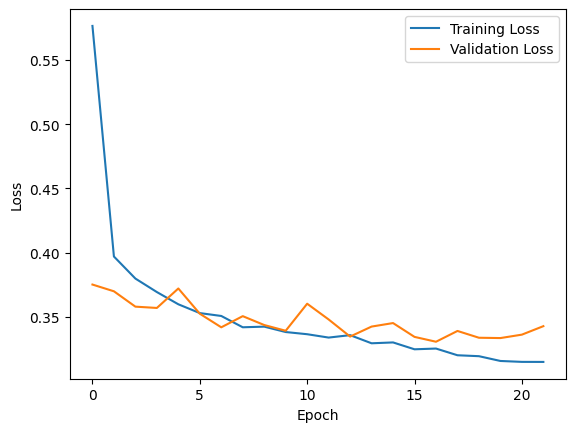

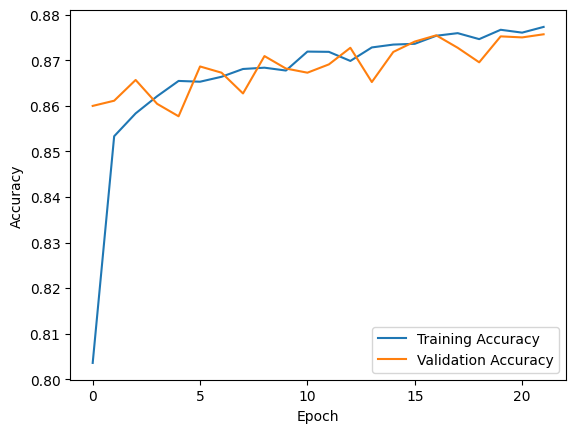

In [9]:
# Eğitim ve doğrulama kaybını çiz
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Eğitim ve doğrulama doğruluğunu çiz
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Sınıf İsimleri: ['N', 'H', 'M', 'G', 'A', 'O', 'C', 'D']
Seçilen Sınıf: M
Seçilen Görsel: /kaggle/input/classed-odir5k-splited-into-train-test/test/M/aug_0_3175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


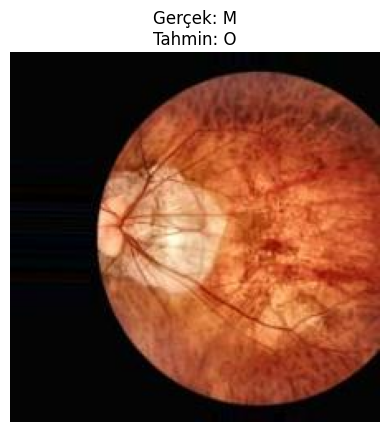

Gerçek Sınıf: M
Tahmin Edilen Sınıf: O


In [10]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Test dizinindeki klasörleri ve dosyaları listele
class_names = os.listdir(test_dir)  # Klasör isimleri (sınıf isimleri)
print("Sınıf İsimleri:", class_names)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
print("Seçilen Sınıf:", random_class)

# Seçilen sınıf içinden rastgele bir görsel seç
random_image_name = random.choice(os.listdir(os.path.join(test_dir, random_class)))
random_image_path = os.path.join(test_dir, random_class, random_image_name)
print("Seçilen Görsel:", random_image_path)

# Görseli yükle ve model için hazırla
img = image.load_img(random_image_path, target_size=(224, 224))  # Görseli 224x224 boyutuna getir
img_array = image.img_to_array(img)  # Görseli numpy array'e dönüştür
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Model ile tahmin yap
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]  # En yüksek olasılıklı sınıfın indeksi
predicted_class_name = class_names[predicted_class_index]  # Sınıf ismi

# Gerçek etiket
true_class_name = random_class

# Sonuçları göster
plt.imshow(img)
plt.title(f"Gerçek: {true_class_name}\nTahmin: {predicted_class_name}")
plt.axis("off")
plt.show()

# Tahmin ve gerçek değerleri yazdır
print(f"Gerçek Sınıf: {true_class_name}")
print(f"Tahmin Edilen Sınıf: {predicted_class_name}")

Sınıf İsimleri: ['N', 'H', 'M', 'G', 'A', 'O', 'C', 'D']
Seçilen Sınıf: G
Seçilen Görsel: /kaggle/input/classed-odir5k-splited-into-train-test/test/G/aug_0_6555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


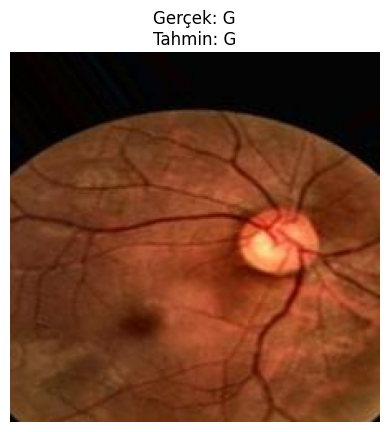

Gerçek Sınıf: G
Tahmin Edilen Sınıf: G


In [16]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Test dizinindeki klasörleri ve dosyaları listele
class_names = os.listdir(test_dir)  # Klasör isimleri (sınıf isimleri)
print("Sınıf İsimleri:", class_names)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
print("Seçilen Sınıf:", random_class)

# Seçilen sınıf içinden rastgele bir görsel seç
random_image_name = random.choice(os.listdir(os.path.join(test_dir, random_class)))
random_image_path = os.path.join(test_dir, random_class, random_image_name)
print("Seçilen Görsel:", random_image_path)

# Görseli yükle ve model için hazırla
img = image.load_img(random_image_path, target_size=(224, 224))  # Görseli 224x224 boyutuna getir
img_array = image.img_to_array(img)  # Görseli numpy array'e dönüştür
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Model ile tahmin yap
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]  # En yüksek olasılıklı sınıfın indeksi
predicted_class_name = class_names[predicted_class_index]  # Sınıf ismi

# Gerçek etiket
true_class_name = random_class

# Sonuçları göster
plt.imshow(img)
plt.title(f"Gerçek: {true_class_name}\nTahmin: {predicted_class_name}")
plt.axis("off")
plt.show()

# Tahmin ve gerçek değerleri yazdır
print(f"Gerçek Sınıf: {true_class_name}")
print(f"Tahmin Edilen Sınıf: {predicted_class_name}")

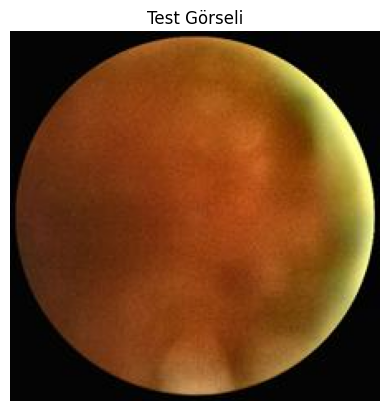

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Tahmin Edilen Sınıf: H
Tahmin Olasılıkları: [5.9015503e-07 9.9586934e-01 1.2238792e-05 3.0340726e-04 4.1122098e-07
 1.5137917e-07 2.6931472e-03 1.1207564e-03]


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Görselin yolunu belirtin
image_path = "/kaggle/input/eski-veri-seti-snf-karm/C/1285_left.jpg"  # Görselin yolunu buraya yazın

# Görseli yükle ve 224x224 boyutuna getir
img = image.load_img(image_path, target_size=(224, 224))  # Görseli 224x224 boyutuna getir

# Görseli numpy array'e dönüştür
img_array = image.img_to_array(img)  # Görseli numpy array'e dönüştür
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle (1, 224, 224, 3)

# Normalizasyon işlemi (EfficientNet için gerekli)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Görseli ekranda göster
plt.imshow(img)
plt.axis("off")
plt.title("Test Görseli")
plt.show()

# Model ile tahmin yap
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]  # En yüksek olasılıklı sınıfın indeksi

# Sınıf isimlerini yükle (test_dir içindeki klasör isimleri)
class_names = os.listdir(test_dir)  # test_dir içindeki klasör isimleri
predicted_class_name = class_names[predicted_class_index]  # Tahmin edilen sınıf ismi

# Tahmin sonucunu yazdır
print(f"Tahmin Edilen Sınıf: {predicted_class_name}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

başka verisetinden yanlış tahmin

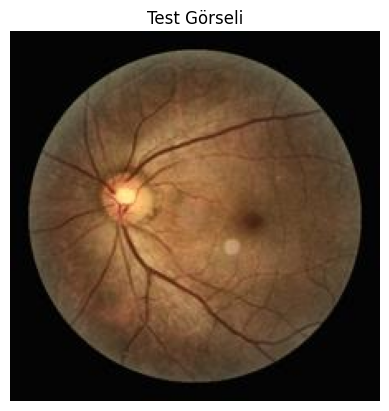

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Tahmin Edilen Sınıf: C
Tahmin Olasılıkları: [5.8633145e-02 3.1969327e-04 2.7500996e-01 2.6119316e-03 1.7406425e-02
 4.0539933e-05 5.0041813e-01 1.4556023e-01]


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Görselin yolunu belirtin
image_path = "/kaggle/input/eski-veri-seti-snf-karm/H/116_left.jpg"  # Görselin yolunu buraya yazın

# Görseli yükle ve 224x224 boyutuna getir
img = image.load_img(image_path, target_size=(224, 224))  # Görseli 224x224 boyutuna getir

# Görseli numpy array'e dönüştür
img_array = image.img_to_array(img)  # Görseli numpy array'e dönüştür
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle (1, 224, 224, 3)

# Normalizasyon işlemi (EfficientNet için gerekli)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Görseli ekranda göster
plt.imshow(img)
plt.axis("off")
plt.title("Test Görseli")
plt.show()

# Model ile tahmin yap
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]  # En yüksek olasılıklı sınıfın indeksi

# Sınıf isimlerini yükle (test_dir içindeki klasör isimleri)
class_names = os.listdir(test_dir)  # test_dir içindeki klasör isimleri
predicted_class_name = class_names[predicted_class_index]  # Tahmin edilen sınıf ismi

# Tahmin sonucunu yazdır
print(f"Tahmin Edilen Sınıf: {predicted_class_name}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

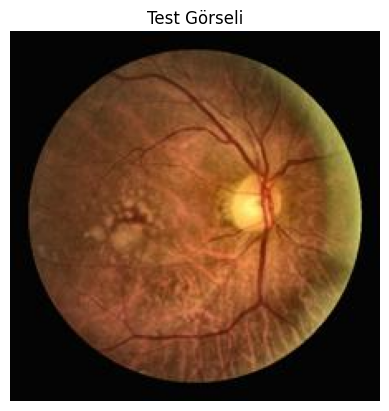

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Rastgele Seçilen Görsel: 1893_right.jpg
Gerçek Sınıf: A
Tahmin Edilen Sınıf: D
Tahmin Olasılıkları: [0.24160668 0.00068699 0.25003636 0.00973037 0.01824694 0.00121855
 0.22817266 0.25030145]


In [54]:
import numpy as np
import tensorflow as tf
import os
import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Test verisinin bulunduğu klasör
test_dir = "/kaggle/input/eski-veri-seti-snf-karm"  # Buraya test verisinin olduğu ana klasörü yazın

# Test klasörleri (sınıflar)
class_names = os.listdir(test_dir)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
class_path = os.path.join(test_dir, random_class)

# Seçilen sınıftan rastgele bir görsel seç
image_name = random.choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# Görseli yükle ve 224x224 boyutuna getir
img = image.load_img(image_path, target_size=(224, 224))

# Görseli numpy array'e dönüştür
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle (1, 224, 224, 3)

# Normalizasyon işlemi (EfficientNet için gerekli)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Görseli ekranda göster
plt.imshow(img)
plt.axis("off")
plt.title("Test Görseli")
plt.show()

# Model ile tahmin yap
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Tahmin edilen sınıf ismi
predicted_class_name = class_names[predicted_class_index]

# Tahmin sonucunu yazdır
print(f"Rastgele Seçilen Görsel: {image_name}")
print(f"Gerçek Sınıf: {random_class}")
print(f"Tahmin Edilen Sınıf: {predicted_class_name}")
print(f"Tahmin Olasılıkları: {predictions[0]}")